# Exploration 07

In [207]:
 !pip install pixellib

In [208]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


- urllib는 웹에서 데이터를 다운로드할 때 사용.
- cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요.
- pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리. 아직 시맨틱 세그멘테이션 모델을 직접 만들기에는 어려우니 이번에는 준비된 모델을 사용.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1440, 2560, 3)


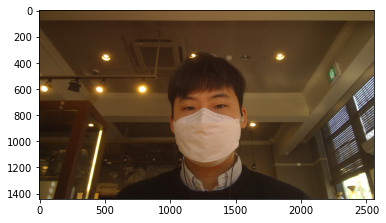

In [209]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# 이미지 경로
cafe_img_path = '/content/drive/MyDrive/LMS/Exploration/Ex.7/images/cafe_my_image.png'
cafe_img_orig = cv2.imread(cafe_img_path)

print(cafe_img_orig.shape)
plt.imshow(cv2.cvtColor(cafe_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 세그멘케이션으로 사람 분리하기

In [210]:
# 저장할 파일 이름 결정
model_dir = '/content/drive/MyDrive/LMS/Exploration/Ex.7/models'
model_file = '/content/drive/MyDrive/LMS/Exploration/Ex.7/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# PixlLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/content/drive/MyDrive/LMS/Exploration/Ex.7/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f97604e9490>)

### 다운로드 한 모델을 이용해 `PixelLib`로 우리가 사용할 세그멘 테이션 모델을 생성

In [211]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

#### 이제 모델에 이미지를 입력

In [212]:
cafe_segvalues, cafe_output = model.segmentAsPascalvoc(cafe_img_path)

(코랩 환경에서 에러가 났는데, 이는 "런타임 다시시작"으로 해결할 수 있었다.)

In [213]:
LABEL_NAMES = [
               'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
               'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

이 중 'person' (15) 를 가진 영역만 검출해 내고싶다면?

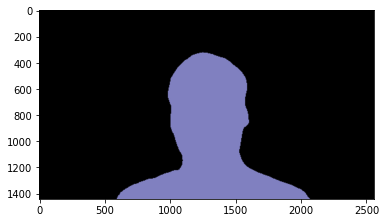

In [214]:
plt.imshow(cafe_output)
plt.show()

In [215]:
cafe_segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [216]:
for class_id in cafe_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


물체마다 output에는 어떤 색상으로 나타나 있는지만 알아내보자.

In [217]:
#아래 코드는 PixelLib에서 그대로 가져왔기 때문에, 이해하지 않아도 된다.
# 단지 색상코드 결과물만 보자.
colormap = np.zeros((256,3),dtype = int)
ind = np.arange(256, dtype = int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:,channel] |= ((ind>>channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [218]:
colormap[15]

array([192, 128, 128])

#### 사람 외에도 다른 물체를 찾아내고 싶다면 `colormap[class_id]`처럼 찾아낼 수 있다.
하지만, `output`이미지가 BGR순서로 채널 배치가 되어있고, `colormap`은 RGB 순서이므로, 추출해야하는 색상값은 순서를 바꾸어 주어야합니다.

In [219]:
cafe_seg_color = (128,128,192)

### `seg_color` 로만 이루어진 마스크를 만들어보자

(1440, 2560)


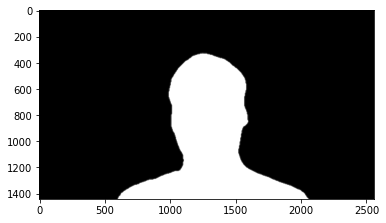

In [220]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
cafe_seg_map = np.all(cafe_output == cafe_seg_color, axis =-1)
print(cafe_seg_map.shape)
plt.imshow(cafe_seg_map, cmap='gray')
plt.show()

### 원래 이미지와 곂쳐 보아, 세그멘테이션이 얼마나 잘 되었는지를 보자.

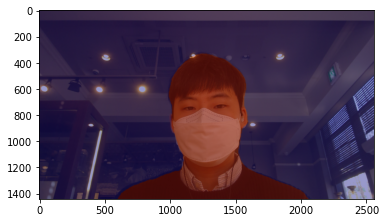

In [221]:
cafe_img_show = cafe_img_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꾸어 줍니다.
img_mask = cafe_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸어 봅시다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅시다.
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
cafe_img_show = cv2.addWeighted(cafe_img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(cafe_img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 흐리게하기

배경 흐리게 하는것은 `blur()`함수를 이용합니다

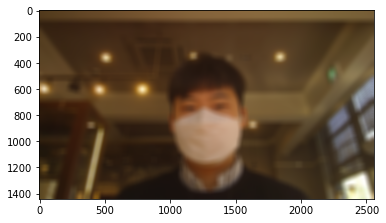

In [222]:
# (13,13)은 blurring Kernel size 를 뜻합니다.
# 다양하게 바꿔보세요.
cafe_img_orig_blur = cv2.blur(cafe_img_orig, (50,50))
plt.imshow(cv2.cvtColor(cafe_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐려진 이미지에서 세그메네이션 마스크를 이용해서 배경만 추출

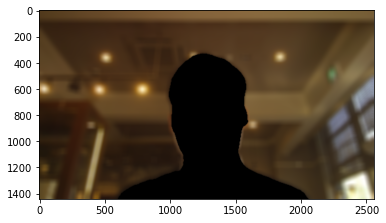

In [223]:
cafe_img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(cafe_img_mask_color)
img_bg_blur = cv2.bitwise_and(cafe_img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 흐린배경과 원본영상 합성

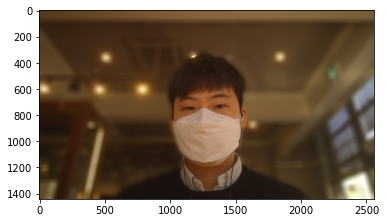

In [224]:
cafe_img_concat = np.where(cafe_img_mask_color == 255, cafe_img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(cafe_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 체크를 위해 저장

In [225]:
img_save_path = '/content/drive/MyDrive/LMS/Exploration/Ex.7/images/cafe_img_done.png'
cv2.imwrite(img_save_path,cafe_img_concat)

True

## 세 장 이상의 인물사진 모드 만들기

위에 한 장을 했으니, 두 장을 더 해보겠습니다.

#### 이미지2 (헤드폰+ 고개 + 의자배경)

(720, 1280, 3)


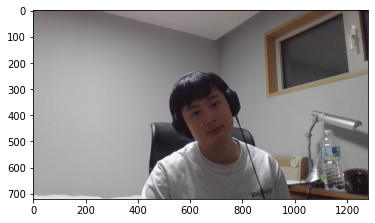

In [226]:
# 이미지 경로
home_img_path = '/content/drive/MyDrive/LMS/Exploration/Ex.7/images/home_img.png'
home_img_orig = cv2.imread(home_img_path)

print(home_img_orig.shape)
plt.imshow(cv2.cvtColor(home_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### 세그멘테이션

In [227]:
home_segvalues, home_output = model.segmentAsPascalvoc(home_img_path)

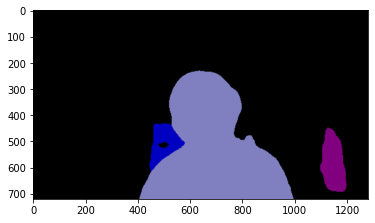

In [228]:
plt.imshow(home_output)
plt.show()

In [229]:
home_segvalues

{'class_ids': array([ 0,  5,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [230]:
for class_id in home_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
chair
person


### 각 물체 색상 알아보기

In [231]:
colormap = np.zeros((256,3),dtype = int)
ind = np.arange(256, dtype = int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:,channel] |= ((ind>>channel) & 1) << shift
    ind >>= 3

print(colormap[5])
print(colormap[9])
print(colormap[15])

[128   0 128]
[192   0   0]
[192 128 128]


#### 세그멘테이션 색 지정

In [232]:
home_seg_color = (128,128,192)

### seg_color로만 이루어진 mask 만들기

(720, 1280)


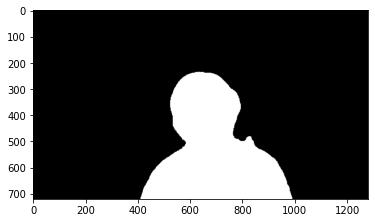

In [233]:
home_seg_map = np.all(home_output == home_seg_color, axis =-1)
print(home_seg_map.shape)
plt.imshow(home_seg_map, cmap='gray')
plt.show()

#### 원래 이미지와, 세그멘테이션과 곂쳐보기

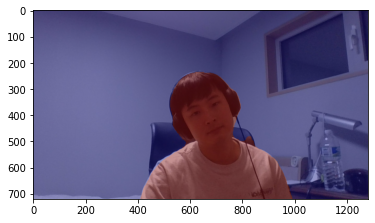

In [234]:
home_img_show = home_img_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꾸어 줍니다.
img_mask = home_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸어 봅시다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅시다.
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
home_img_show = cv2.addWeighted(home_img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(home_img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기

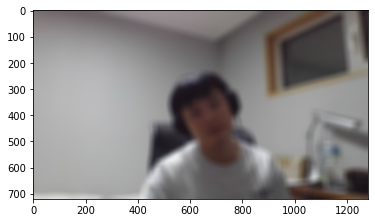

In [235]:
home_img_orig_blur = cv2.blur(home_img_orig, (30,30))
plt.imshow(cv2.cvtColor(home_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경만 추출

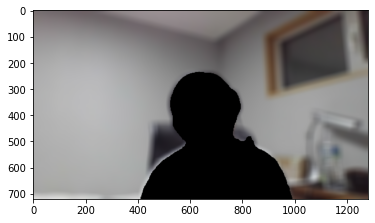

In [236]:
home_img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(home_img_mask_color)
home_img_bg_blur = cv2.bitwise_and(home_img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(home_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 이미지 합성

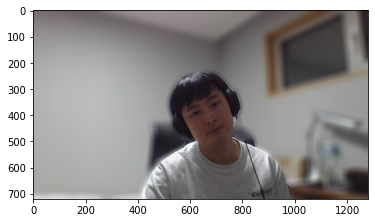

In [237]:
home_img_concat = np.where(home_img_mask_color == 255, home_img_orig, home_img_bg_blur)
plt.imshow(cv2.cvtColor(home_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 체크를 위해 저장

In [238]:
img_save_path = '/content/drive/MyDrive/LMS/Exploration/Ex.7/images/home_img_done.png'
cv2.imwrite(img_save_path,home_img_concat)

True

#### 이미지3 (후드 집업 + 의자 배경과 같은 후드 색)

(720, 1280, 3)


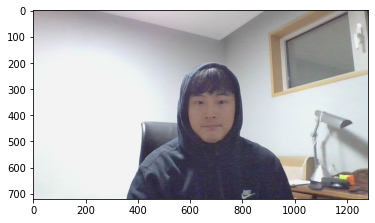

In [239]:
# 이미지 경로
zip_img_path = '/content/drive/MyDrive/LMS/Exploration/Ex.7/images/zip_img.png'
zip_img_orig = cv2.imread(zip_img_path)

print(zip_img_orig.shape)
plt.imshow(cv2.cvtColor(zip_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### 세그멘테이션

In [240]:
zip_segvalues, zip_output = model.segmentAsPascalvoc(zip_img_path)

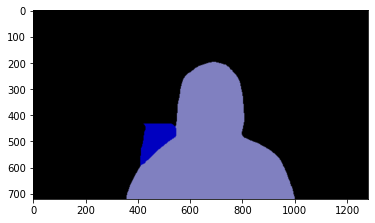

In [241]:
plt.imshow(zip_output)
plt.show()

In [242]:
zip_segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [243]:
for class_id in zip_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


### 각 물체 색상 알아보기

In [244]:
colormap = np.zeros((256,3),dtype = int)
ind = np.arange(256, dtype = int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:,channel] |= ((ind>>channel) & 1) << shift
    ind >>= 3

print(colormap[9])
print(colormap[15])

[192   0   0]
[192 128 128]


#### 세그멘테이션 색 지정

In [245]:
zip_seg_color = (128,128,192)

### seg_color로만 이루어진 mask 만들기

(720, 1280)


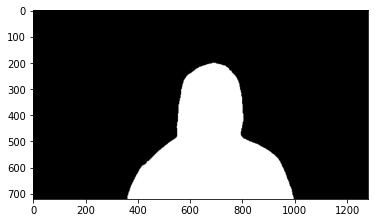

In [246]:
zip_seg_map = np.all(zip_output == zip_seg_color, axis =-1)
print(zip_seg_map.shape)
plt.imshow(zip_seg_map, cmap='gray')
plt.show()

#### 원래 이미지와, 세그멘테이션과 곂쳐보기

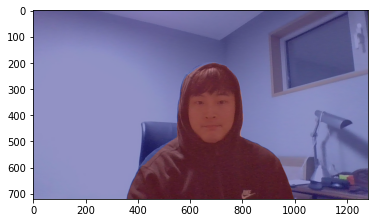

In [247]:
zip_img_show = zip_img_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꾸어 줍니다.
img_mask = zip_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸어 봅시다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅시다.
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
zip_img_show = cv2.addWeighted(zip_img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(zip_img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기

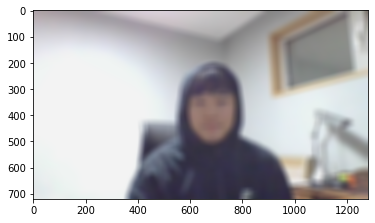

In [248]:
zip_img_orig_blur = cv2.blur(zip_img_orig, (30,30))
plt.imshow(cv2.cvtColor(zip_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경만 추출

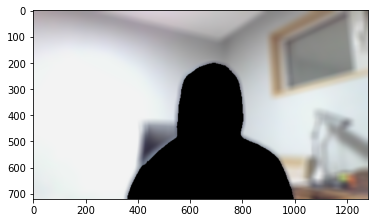

In [249]:
zip_img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(zip_img_mask_color)
zip_img_bg_blur = cv2.bitwise_and(zip_img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(zip_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 이미지 합성

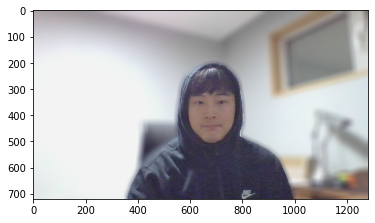

In [250]:
zip_img_concat = np.where(zip_img_mask_color == 255, zip_img_orig, zip_img_bg_blur)
plt.imshow(cv2.cvtColor(zip_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 체크를 위해 저장

In [251]:
img_save_path = '/content/drive/MyDrive/LMS/Exploration/Ex.7/images/zip_img_done.png'
cv2.imwrite(img_save_path,zip_img_concat)

True

## 고양이나 강아지에 대한 아웃 포커싱 사진도 만들어 보기.
- 시멘틱 세그멘테이션 스텝에서 힌트를 찾아볼 수 있다.

(4032, 3024, 3)


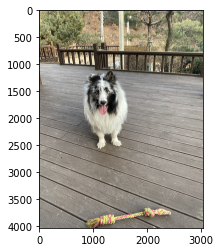

In [252]:
dog_img_path = '/content/drive/MyDrive/LMS/Exploration/Ex.7/images/dog_img.png'
dog_img_orig = cv2.imread(dog_img_path)

print(dog_img_orig.shape)
plt.imshow(cv2.cvtColor(dog_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [253]:
dog_segvalues, dog_output = model.segmentAsPascalvoc(dog_img_path)

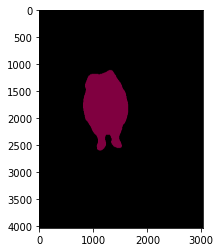

In [254]:
plt.imshow(dog_output)
plt.show()

In [255]:
dog_segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [256]:
for class_id in dog_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [257]:
colormap = np.zeros((256,3),dtype = int)
ind = np.arange(256, dtype = int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:,channel] |= ((ind>>channel) & 1) << shift
    ind >>= 3

print(colormap[12])

[ 64   0 128]


In [258]:
dog_seg_color = (128,0,64)

(4032, 3024)


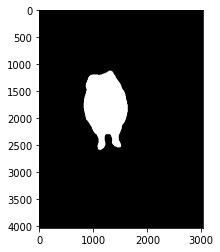

In [259]:
dog_seg_map = np.all(dog_output == dog_seg_color, axis =-1)
print(dog_seg_map.shape)
plt.imshow(dog_seg_map, cmap='gray')
plt.show()

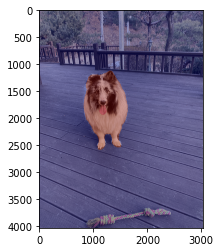

In [260]:
dog_img_show = dog_img_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꾸어 줍니다.
img_mask = dog_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸어 봅시다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅시다.
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
dog_img_show = cv2.addWeighted(dog_img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(dog_img_show, cv2.COLOR_BGR2RGB))
plt.show()

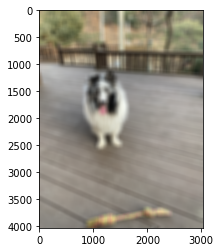

In [261]:
dog_img_orig_blur = cv2.blur(dog_img_orig, (100,100))
plt.imshow(cv2.cvtColor(dog_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

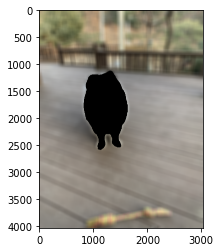

In [262]:
dog_img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(dog_img_mask_color)
dog_img_bg_blur = cv2.bitwise_and(dog_img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(dog_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

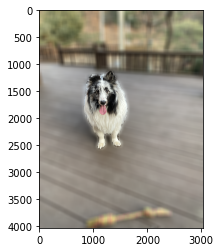

In [263]:
dog_img_concat = np.where(dog_img_mask_color == 255, dog_img_orig, dog_img_bg_blur)
plt.imshow(cv2.cvtColor(dog_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [264]:
img_save_path = '/content/drive/MyDrive/LMS/Exploration/Ex.7/images/dog_img_done.png'
cv2.imwrite(img_save_path,dog_img_concat)

True

## 배경을 blur하는 인물모드 사진이 아니라, 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도 해 볼 수도 있다.

#### 시도해볼 배경

(1440, 1920, 3)


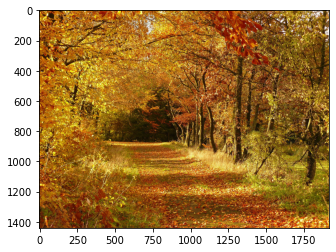

In [265]:
back_img_path = '/content/drive/MyDrive/LMS/Exploration/Ex.7/images/back.png'
back_img_orig = cv2.imread(back_img_path)

print(back_img_orig.shape)
plt.imshow(cv2.cvtColor(back_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경사진 사이즈에 맞게, 이미지 배열을 조정 하였다

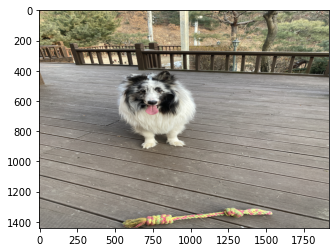

In [266]:
from PIL import Image
import glob

img_path = '/content/drive/MyDrive/LMS/Exploration/Ex.7/images/resize_dog.png'
img_here = glob.glob(img_path)
old_img = Image.open(img_path)
dog_img_resize = old_img.resize((1920,1440),Image.ANTIALIAS) # ANTIALIAS: 위신호제거: 깨진 패턴형태를 최소화 해준다.
dog_img_resize.save(img_path)

plt.imshow(dog_img_resize)
plt.show()

(1440, 1920, 3)


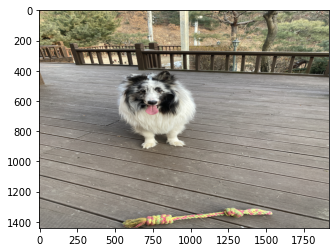

In [267]:
dog_img_path = '/content/drive/MyDrive/LMS/Exploration/Ex.7/images/resize_dog.png'
dog_img_orig = cv2.imread(dog_img_path)

print(dog_img_orig.shape)
plt.imshow(cv2.cvtColor(dog_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [268]:
dog_segvalues, dog_output = model.segmentAsPascalvoc(dog_img_path)

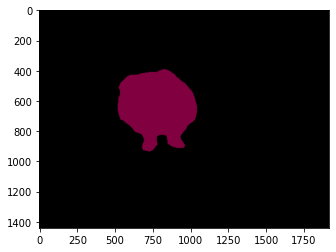

In [269]:
plt.imshow(dog_output)
plt.show()

In [270]:
for class_id in dog_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [271]:
colormap = np.zeros((256,3),dtype = int)
ind = np.arange(256, dtype = int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:,channel] |= ((ind>>channel) & 1) << shift
    ind >>= 3

print(colormap[0])

[0 0 0]


#### 이번엔 배경 블러가 아닌, 강아지만 따로 빼 낼 계획이므로, 배경을 세그멘테이션 색으로 지정해 주었다.

In [272]:
dog_seg_color = (0,0,0)

(1440, 1920)


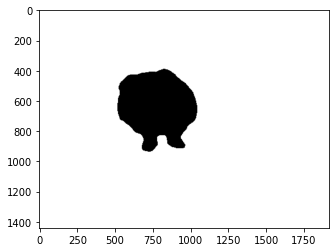

In [273]:
dog_seg_map = np.all(dog_output == dog_seg_color, axis =-1)
print(dog_seg_map.shape)
plt.imshow(dog_seg_map, cmap='gray')
plt.show()

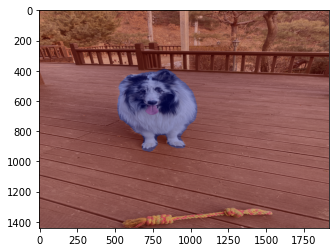

In [274]:
dog_img_show = dog_img_orig.copy()

img_mask = dog_seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

dog_img_show = cv2.addWeighted(dog_img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(dog_img_show, cv2.COLOR_BGR2RGB))
plt.show()

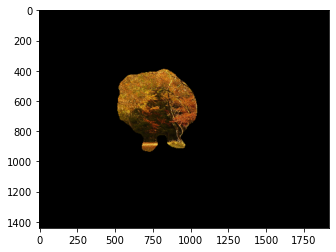

In [275]:
dog_img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(dog_img_mask_color)
dog_img_bg = cv2.bitwise_and(back_img_orig, img_bg_mask)
plt.imshow(cv2.cvtColor(dog_img_bg, cv2.COLOR_BGR2RGB))
plt.show()

위의 예시들과는 다르게, 배경과 강아지의 위치를 바꾸어 주었다.

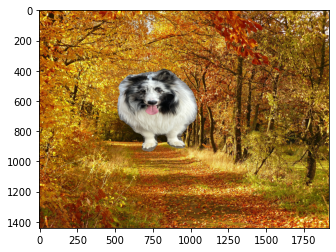

In [276]:
dog_img_concat = np.where(dog_img_mask_color == 255, back_img_orig, dog_img_orig)
plt.imshow(cv2.cvtColor(dog_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

어색하지만 합성에는 성공하였다.

## 사진에서 문제점 찾기


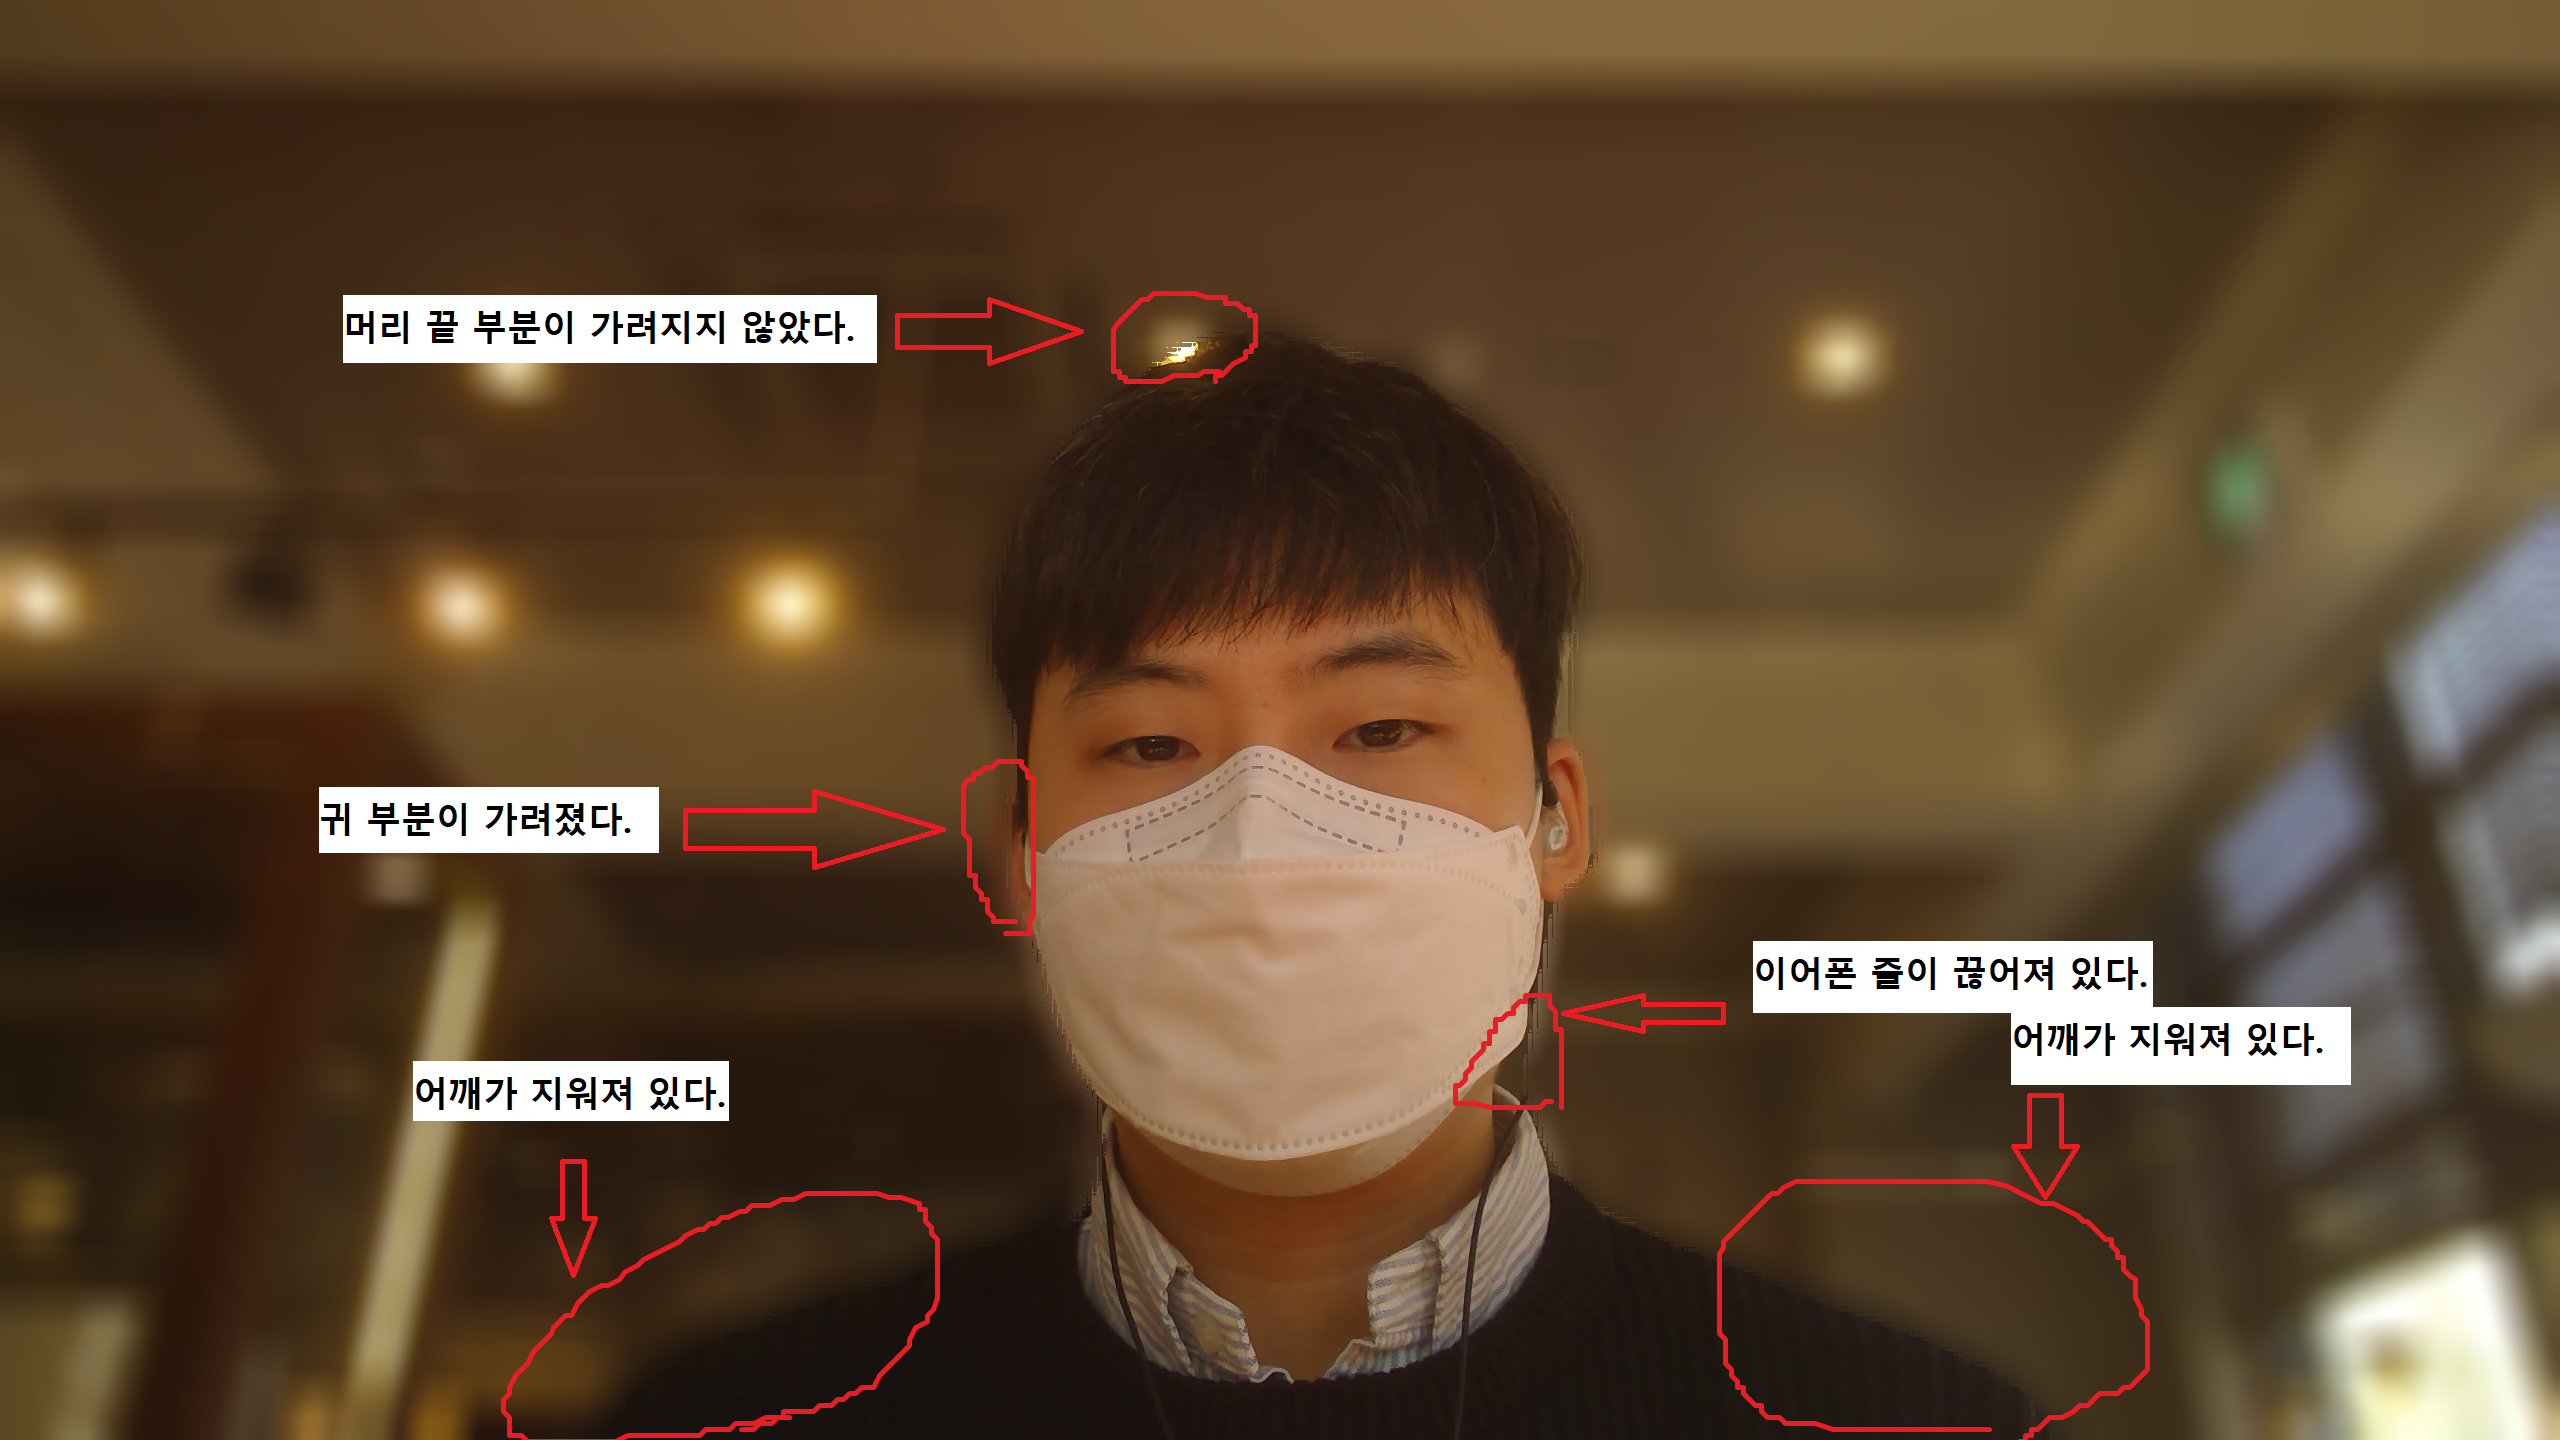

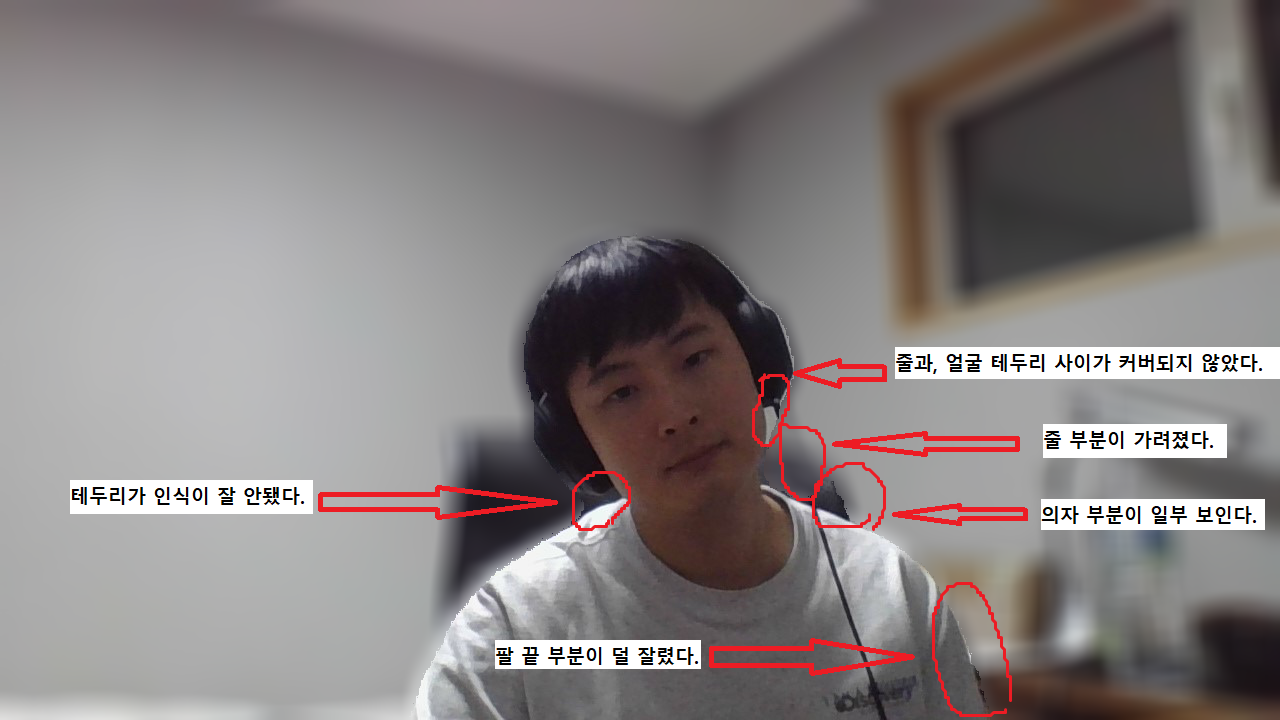

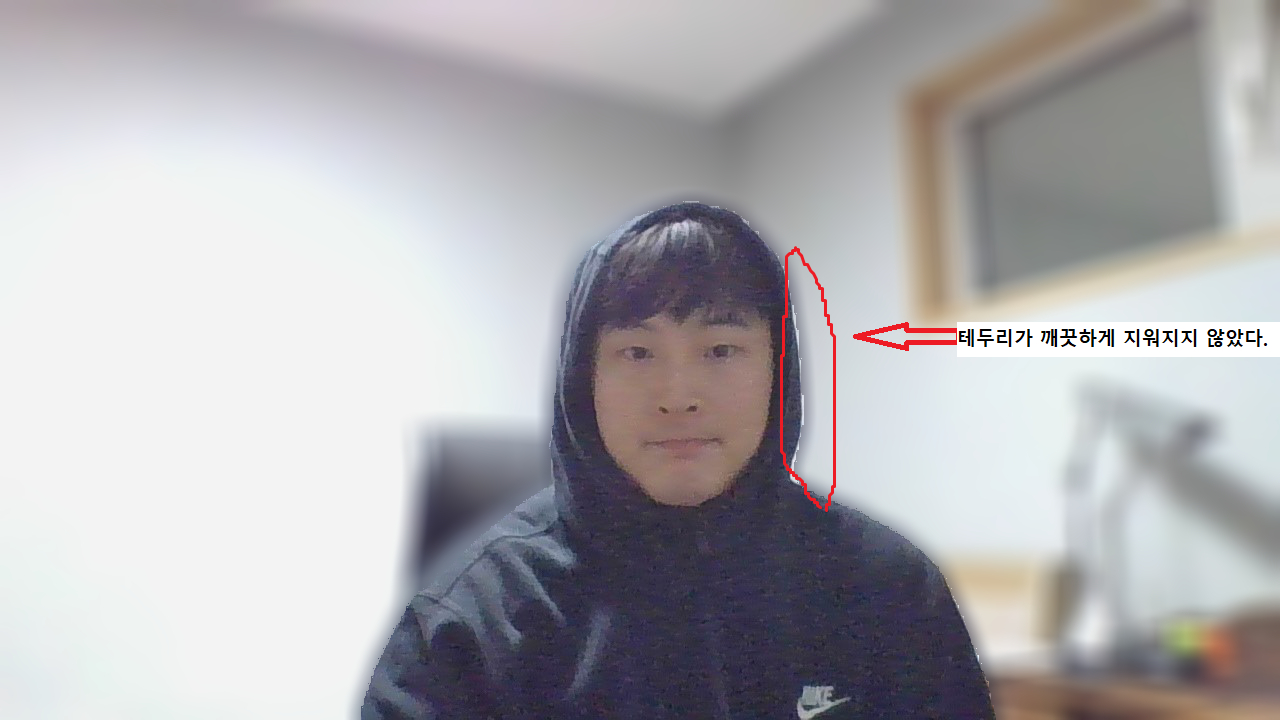

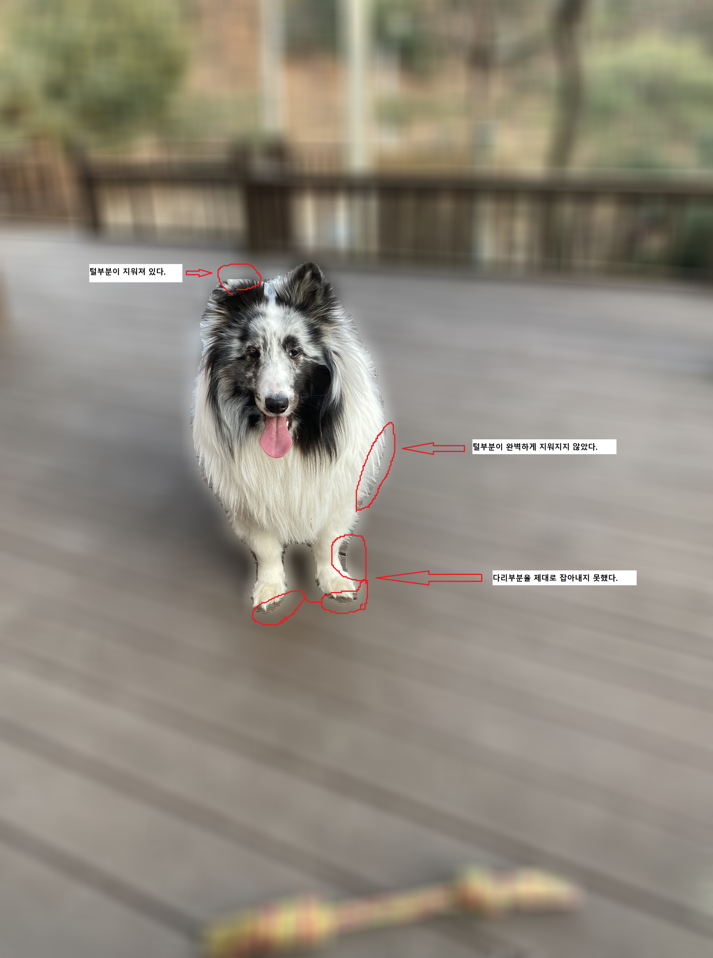

## 해결 방법을 제안해보기
## 세그멘테이션의 한계
참고 자료: https://medium.com/hyunjulie/1%ED%8E%B8-semantic-segmentation-%EC%B2%AB%EA%B1%B8%EC%9D%8C-4180367ec9cb

- 구글 IA는, Semantic Segmentation 모델인 DeepLab V3+를 사용해서, Pixel Phone에 Portrait Mode를 구현했고, 아이폰은 Portrait Mode를 딥러닝이 아닌, 카메라 2개를 사용하여 같은 효과를 만들었다고 합니다.

#### Semantic Image Segmentation의 목적:
- 사진에 있는 모든 픽셀을 해당하는 class로 분류 하는 것.

#### Semantic Segmentation Task 이해:
- 원-핫 인코딩으로 각 클래스에 대한 출력채널을 만들어서 Segmentation map을 만들어, 클래스의 개수만큼 만들어진 채널을 `argmax`를 통하여 이미지 처럼 하나의 출력물을 내놓습니다.

- 단순히 xx 기술을 사용한다. 정도가 아닌, 우리가 선택한 기술이 DeepLab 모델의 Semantic Segmentation이 만들어낸 Mask영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션

#### 다양한 Semantic Segmentation 방법들:
- Downsampling: 주 목적은 차원을 줄여서 적은 메모리로 convolution 하는 것.
- Upsampling: Downsampling을 통해 받은 결과의 차원을 늘려 인풋과 같은 차원으로 만들어 주는 과정

이러한 형태의 모델을 사용하는데 큰 몫을 한 FCN:
#### Fully Convolutional Network for Semantic Segmentation (FCN):
모델의 특징:
- VGG16으로부터 Tranfer Learning을 사용한다.
- VGG16의 마지막 layer인 fully connected layer을 1x1의 convolution layer로 바꾼다. 이 부분에서 이 모델의 이름인 ‘fully convolutional’이 나온다. 이를 통해서 낮은 해상도의 Class Presence Heat Map 을 얻는다.
Fully Connected Layer를 없앤 이유는 마지막에 이 Layer 를 거치고 나면 위치 정보가 사라지는 문제가 있기 때문이다.
- Transposed Convolution 을 통해서 이 낮은 해상도의 heap map 을 업샘플링 해서 인풋과 같은 크기의 맵을 만든다
- 업샘플링을 할 때 VGG16의 낮은 layer 의 특징맵을 더한다
- 여러 단의 Convolutional Layer 중에 후반부에 있는 특징맵을 결합하면 중요한 정보를 얻을 수 있다는 것을 설명했습니다
- 각 Convolution Block 이 끝난 후 Skip Connection 을 통해서 이전에 pooled 된 특징들을 다시한번 합쳐준다

하지만, FCN 모델은 정해진 Receptive Field 를 사용해서 작은 물체들은 무시가 되거나 이상하게 인식 될 수 있고, 큰 물체를 작은 물체로 인식하거나 일정하지 않은 결과가 나올 수 있습니다. 또한, Pooling 을 거치면서 해상도가 줄어든 것을 Upsampling을 통해서 복원하는 방식을 사용해서, 결과가 정확하지 않다는 문제점을 가지고 있습니다.


## Dilated/Atrous Convolution을 사용하는 방법.
- Deeplab 이 제시하는 방법으로, 신호가 소멸되는것을 제어하고 다양한 크기의 특징을 익히는 방법을 제시합니다. Atrous Convolution 은 dilation rate (확장 비율)이라는 새로운 변수를 사용합니다. 이 비율은 커널에서 사용할 값들 사이에 얼마 만큼의 공간을 넣어줄 것인지에 대한 것입니다. 커널 안에 공간이 없는 일반적인 convolution 은 확장비율은 1로 정의합니다. 3 x 3 의 크기의 커널이 2의 확장비율을 갖는다면 실제로는 5 x 5 커널의 시야를 갖게 됩니다. 위와 같은 방법은 동일한 계산 비용으로 보다 넓은 시야를 갖을 수 있게 합니다.
- Deeplab V3는 ImageNet에서 학습된 ResNet을 기본적인 특징 추출기로 사용합니다. ResNet의 마지막 블럭에서는 여러가지 확장비율을 사용한 Atrous Convolution을 사용해서 다양한 크기의 특징들을 뽑아낼 수 있도록 합니다.

# 회고

#### 아웃 포커싱 효과가 적용된 본인의 인물모드 사진과 강아지사진, 배경전환 크로마키 사진을 각각 1장 이상 성곡적으로 제작하였다.
- 우선, 인물사진의 경우, 고개를 돌려 경계선이 모호해 지면 테두리를 인식하는게 다소 정확도가 떨어짐을 알 수 있었습니다.
- 또한, 이어폰 줄 같은경우에는 얇기 때문인지 확실하게 인지하지 못했었습니다.
- 일부러 의자색과 같은 후드집업을 입어보고, 모자도 써 보았는데, 우선 의자색과 같음은 상관이 없었던 것으로 파악이 됩니다. 아마 거리를 감지하기 때문이 아닌가 추론해 봅니다. 그리고 후드집업의 경우, 경계선이 배경색과 구분이 확실하기 때문인지, 테두리를 매우 잘 지워 주었습니다.

- 강아지 사진같은 경우, 털 부분이 많아 깨끗하게 인식하지 못하였던것 같습니다.

- 마지막 크로마키 사진의 경우에는, 사실 완수하지 못했다고 생각합니다. 우선 가볍게 검색알 해 보았지만, 배경이 초록색인 사진을 구해야하는것인지, 초록색을 만들어내는것인지, 혹은 초록색이 없어도 배경을 바꾸는것인지에 대해 조사가 미흡했습니다. 하지만 다른 방법을 통하여 배경을 바꾸어 보긴 했습니다. 이는, 배경과 강아지 사진의 이미지 배열을 맞추어 주는것이 다소 어려움이 있었기에, 가위바위보 Exploration을 참고하였습니다.

#### 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
- 제가 지적한 부분이 맞는지는 모르겠지만, 다소 어색한 부분들을 짚어 표시하였습니다.

#### 추가적인 depth 정보를 활용하여 semantic segmentation mask 의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.
- 구체적으로 제시하지 못했다고 생각합니다. 솔직하게 말씀드리면, Semantic segmentation 에 구동 원리도 파악하기가 힘들었고, 때문에 검색한 여러가지 해결 방안에 대해서도 정확하게 이해하지 못하였습니다. 정말 부끄럽게 생각합니다.. 다만 가장 유사하고 가장 근거가 될 만한 글을 찾아내어 후에 지식이 더 늘었을 때 이 회고를 돌아 볼때를 대비하여 그 글을 직접 타이핑하여 적어보았습니다.

---
#### 이번 프로젝트에서 어려웠던 점
- 핑계입니다.. 명절이라 시간분배를 제대로 하지 못하여 충분한 조사를 하지 못하였습니다.. 어쨋든, 크로마키를 이용하여 배경전환하는 부분에 대해 정확하게 어떤 기술을 요구하는지 파악을 못하였습니다. 제가 해 낸 단순 배경전환이 맞는지 모르겠습니다. 크로마키를 검색하였더니 영상 cv 처리에서, 배경이 초록색인 부분을 바꾸는 기술로 보았는데, 처음에 강아지사진 뒤를 초록색 배경으로 바꿔야하나? 라고 생각하였지만, 그럴거면 그냥 원하는 배경사진으로 전황하면 되지않나? 라고 생각하여 바로 진행하게 되었습니다. 처음에는 이미지 사이즈가 맞지않아 오류가 났지만, 이는 가위바위보 Exploration을 참고하여 사이즈를 맞추어 진행하였습니다.

#### 프로젝트를 진행하며 알아낸 점 혹은 아직 모호한 점
- 우선 알아낸 것은 단순히, 이런 기술이 구현되어있기 때문에 그냥 모듈만 잘 넣어주면, 이미 준비되어 있는 class를 기반으로 알아서 분류해 주는구나 하고 놀랐습니다.. 그리고 그 외에 모든것들이 모호합니다. 위에도 말씀드렷듯, 크로마키 배경전환에대해 파악하지 못하였고, 마지막 해결방법 제시부분에 대해서는 , 애초에 Semantic Segmentation에 대해 아직 파악이 미흡했기 때문에, 해결방안에 대해 조사를 해 보아도, 각종 어려운 단어들이 나와 이해하기 힘들었습니다..

#### 루브릭 평가 지표를 맞추기 위해 시도한 것들
- 아무리 명절이라지만, 그래도 루브릭 평가지표는 맞추어야 했기에, 크로마키 배경전환은 최대한 이미지 사이즈라도 맞추어 단순 배경 합성하는 시도를 해 보았습니다. 또한, 마지막 해결방안에 대해서는 대부분 알아듣지 못하였지만, 가장 적합하다고 생각되는 글을 찾아내어 첨삭하게 되었습니다.

#### 루브릭 평가 지표를 달성하지 못했을 때 이유에 관한추정
- 전부 다 라고 생각합니다.. 크로마키 배경전환도 제대로 이행하지 못하였다고 생각하고, 또한 마지막 해결방안은 제대로 알아내지도 못하였습니다..

#### 자기다짐
- 이번 Exploration은 정말 부끄러울 만큼 제대로 이행하지 못했던 것 같습니다. 또한 이해하려해도 아직 지식이 부족하다 느껴 읽어도 이해되지 않는 부분이 많았습니다. 때문에, 후에 cv관련 지식을 조금 더 익히게 된다면, 반드시 이번 Exploration에 돌아와서 다시 한 번 이번파트를 돌이켜 보고 다시 시도해 볼 예정입니다.

감사합니다.